<a href="https://colab.research.google.com/github/Kennysaruni/Luhn-s-Algorithm/blob/main/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
df = pd.read_csv('wine-reviews.csv', usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [ ]:
df = df.dropna(subset=['description', 'points'])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


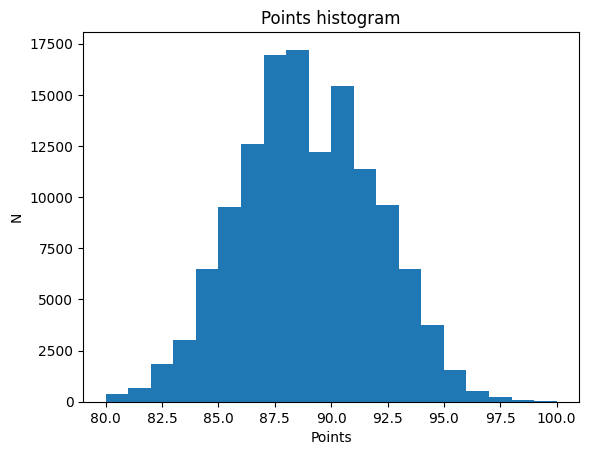

In [ ]:
plt.hist(df.points, bins=20)
plt.title('Points histogram')
plt.ylabel('N')
plt.xlabel('Points')
plt.show()

In [ ]:
df['label'] = (df.points >= 90).astype(int)
df = df[['description', 'label']]

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.8* len(df)), int(0.9*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
len(train), len(val), len(test)

(103976, 12997, 12998)

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df['description']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [38]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, input_shape=[], trainable=True)

In [39]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.36646444, -0.27654156, -0.05337135, ...,  0.10092632,
        -0.07396615, -0.03501109],
       [ 0.54056334, -0.36686587,  0.01476195, ..., -0.19384897,
        -0.09747886,  0.04066996],
       [ 0.19270182, -0.35924658,  0.07498162, ...,  0.28624684,
        -0.06535849, -0.12522529],
       ...,
       [ 0.30940238, -0.11449432,  0.010009  , ...,  0.05189919,
        -0.04827163,  0.01999467],
       [ 0.25428912, -0.3851894 , -0.12828971, ...,  0.05449823,
        -0.16464673,  0.05436781],
       [ 0.49959916, -0.00499037,  0.13170204, ..., -0.1078445 ,
        -0.2862805 ,  0.04624001]], dtype=float32)>

In [40]:
model = tf.keras.Sequential([
     tf.keras.layers.Lambda(lambda x: hub_layer(x)),
     tf.keras.layers.Dense(16, activation='relu'),
     tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(16, activation='relu'),
     tf.keras.layers.Dropout(0.4),
     tf.keras.layers.Dense(1, activation='sigmoid')
])

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss= tf.keras.losses.BinaryCrossentropy(),
              metrics= ['accuracy'])

In [42]:
model.evaluate(train_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5327 - loss: 0.6905


[0.6903517842292786, 0.5344310402870178]

In [43]:
model.evaluate(valid_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5390 - loss: 0.6900


[0.6899247169494629, 0.5417404174804688]

In [47]:
history = model.fit(train_data, validation_data=valid_data, epochs=5)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6840 - loss: 0.5906 - val_accuracy: 0.7047 - val_loss: 0.5700
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6830 - loss: 0.5896 - val_accuracy: 0.7046 - val_loss: 0.5696
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6848 - loss: 0.5878 - val_accuracy: 0.7045 - val_loss: 0.5684
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6863 - loss: 0.5856 - val_accuracy: 0.7055 - val_loss: 0.5692
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6890 - loss: 0.5830 - val_accuracy: 0.7064 - val_loss: 0.5687


In [49]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7014 - loss: 0.5705


[0.5706021189689636, 0.7039544582366943]

In [50]:
encoder = tf.keras.layers.TextVectorization(max_tokens = 2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [51]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [52]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [53]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss= tf.keras.losses.BinaryCrossentropy(),
              metrics= ['accuracy'])

In [54]:
model.evaluate(train_data)
model.evaluate(valid_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 172ms/step - accuracy: 0.5332 - loss: 0.6929
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - accuracy: 0.5367 - loss: 0.6929


[0.6929505467414856, 0.533430814743042]

In [55]:
history = model.fit(train_data, validation_data=valid_data, epochs=5)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 53s 485ms/step - accuracy: 0.6593 - loss: 0.6161 - val_accuracy: 0.8243 - val_loss: 0.3822
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 79s 453ms/step - accuracy: 0.8341 - loss: 0.3810 - val_accuracy: 0.8373 - val_loss: 0.3586
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 49s 478ms/step - accuracy: 0.8441 - loss: 0.3560 - val_accuracy: 0.8358 - val_loss: 0.3556
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 81s 468ms/step - accuracy: 0.8466 - loss: 0.3502 - val_accuracy: 0.8376 - val_loss: 0.3527
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 47s 458ms/step - accuracy: 0.8511 - loss: 0.3401 - val_accuracy: 0.8387 - val_loss: 0.3530


In [56]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - accuracy: 0.8463 - loss: 0.3418


[0.3417811691761017, 0.8476688861846924]